In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Déf des paramètres

d = 2 # Dim de l'espace dans lequel vivent les courbes
n = 20 # Nb d'éléments des courbes
r = n # Nb de vecteurs dans la famille gén

In [28]:
# Déf des courbes

def ellipse_torch(a,b,rot):
    theta = torch.linspace(0,2*np.pi,n+1, dtype=torch.float64)
    rot_tensor = torch.tensor(rot) 
    x = a*torch.cos(theta)*torch.cos(rot_tensor) - b*torch.sin(theta)*torch.sin(rot_tensor)
    y = a*torch.cos(theta)*torch.sin(rot_tensor) + b*torch.sin(theta)*torch.cos(rot_tensor)
    return x,y

x1,x2 = ellipse_torch(4,2,0)
y1,y2 = ellipse_torch(4,2,1)

x1_vect, x2_vect = x1[:-1].unsqueeze(1), x2[:-1].unsqueeze(1)
y1_vect, y2_vect = y1[:-1].unsqueeze(1), y2[:-1].unsqueeze(1)

In [29]:
# Déf des déformations 

def noyau_gauss_torch(sigma,x_tensor,y_tensor):
    '''
    Args : 
    sigma : réel > 0
    x_tensor : tableau de taille (n1,d) : liste de n1 vecteurs de R^d : (x_1, ..., x_n1)
    y_tensor : tableau de taille (n2,d) : liste de n2 vecteurs de R^d : (y_1, ..., y_n2)
    
    Retour : matrice de taille (n1,n2) des noyaux gaussiens des paires de vecteurs de x_tensor et y_tensor : K_sigma(x_i, y_j)
    '''
    distances_carre = torch.sum((x_tensor.unsqueeze(1) - y_tensor)**2, dim=2)
    return torch.exp(-distances_carre / (2*sigma**2))

def champ_vect_torch(sigma,a_tensor,x_tensor,z_tensor):
    '''
    Args :
    sigma : réel > 0
    a_tensor : tableau de taille (r,d) : liste de r vect de R^d formant de la famille gén du champ
    x_tensor : tableau de taille (n,d) : liste de n vect de R^d, variables du champ : (x_1, ..., x_n)
    z_tensor : tableau de taille (r,d) : liste de r vect de R^d formant les points de base du champ

    Retour : tableau de taille (n,d) : liste des évals du champ en chacun des vect de x_tensor : (v(x_1), ..., v(x_n))
    '''
    noyaux = noyau_gauss_torch(sigma,x_tensor,z_tensor)
    return torch.matmul(noyaux,a_tensor)

def deform_torch(sigma,a_tensor,x_tensor,z_tensor):
    '''
    Args : idem que fonction précédente

    Retour : tableau de taille (n,d) : liste des évals de la déform en chacun des vect de x_tensor : (phi(x_1), ..., phi(x_n))
    '''
    return x_tensor + champ_vect_torch(sigma,a_tensor,x_tensor,z_tensor)

sigma = 1
a_tensor = torch.tensor([[1,0],[0,1]], dtype=float)
z_tensor = torch.tensor([[0,0],[1,1]], dtype=float)
x_tensor = torch.tensor([[1,0]], dtype=float)
y_tensor = torch.tensor([[0,0],[1,1],[2,2]], dtype=float)

deform_torch(sigma,a_tensor,x_tensor,z_tensor)

tensor([[1.6065, 0.6065]], dtype=torch.float64)

In [30]:
# Déf des fonctions pour calculer l'énergie

def dist_torch(courbe1,courbe2): 
    '''
    Args : courbe1,courbe2 : tableaux de taille (n,d) : courbes de R^d constituées chacune de n points
    
    Retour : distance entre les 2 courbes
    '''
    return torch.sum(torch.stack([torch.linalg.norm(courbe1[i] - courbe2[i])**2 for i in range(n)]))


def cout_torch(a_tensor): 
    '''
    Args : a_tensor : tableau de taille (r,d) : liste de r vect de R^d formant de la famille gén du champ
    
    Retour : coût de la déformation associée à la famille gén
    '''
    return 1/2 * torch.sum(torch.stack([torch.linalg.norm(a_tensor[i])**2 for i in range(r)]))

def energie_torch(lambd,sigma,a_tensor,z_tensor,courbe1,courbe2): 
    '''
    Args : 
    lambd, sigma : réels > 0
    a_tensor : tableau de taille (r,d) : liste de r vect de R^d formant de la famille gén du champ
    z_tensor : tableau de taille (r,d) : liste de r vect de R^d formant les points de base du champ
    courbe1,courbe2 : tableaux de taille (n,d) : courbes de R^d constituées chacune de n points
    
    Retour : énergie de la déformation associée aux paramètres
    '''
    courbe1_deform = deform_torch(sigma,a_tensor,courbe1,z_tensor)
    return cout_torch(a_tensor) + lambd*dist_torch(courbe1_deform, courbe2)

In [15]:
# Ex calcul énergie d'une déformation et gradient de l'énergie 

lambd = 1
sigma = 1 

courbe1 = torch.cat((x1_vect,x2_vect), dim=1)
courbe2 = torch.concatenate((y1_vect,y2_vect), dim=1)
z_tensor = courbe1

a_tensor_ex = torch.ones((r,d), dtype=torch.float64, requires_grad=True)

energie_val_ex = energie_torch(lambd,sigma,a_tensor_ex,z_tensor,courbe1,courbe2)
energie_val_ex.backward()

energie_val_ex.item(), a_tensor_ex.grad

(527.8727939662888,
 tensor([[36.3702,  2.7382],
         [37.0924,  4.0520],
         [33.5227,  5.6046],
         [26.1724,  7.3007],
         [19.9481,  9.6652],
         [16.4186, 13.3945],
         [14.7768, 19.1312],
         [14.7400, 28.2276],
         [15.2091, 39.1275],
         [14.4531, 45.4931],
         [12.6061, 46.2381],
         [10.0441, 43.0845],
         [ 6.3934, 34.3115],
         [ 2.8727, 21.7445],
         [ 1.7098, 11.9927],
         [ 3.0876,  6.1117],
         [ 6.8811,  2.5266],
         [14.3051,  0.8175],
         [24.7071,  0.7886],
         [32.6835,  1.6434]], dtype=torch.float64))

In [31]:
# Descente de gradient

def descente_gradient_energie(lambd,sigma,epsilon,a_tensor_init,z_tensor,courbe1,courbe2):
    '''
    Args :
    lambd, sigma : réels > 0
    epsilon : réel > 0 donnant la condition d'arrêt de l'algo
    a_tensor_init : tableau de taille (r,d) : liste de r vect de R^d, approximation initiale de la famille gén optimale du champ
    z_tensor : tableau de taille (r,d) : liste de r vect de R^d formant les points de base du champ
    courbe1,courbe2 : tableaux de taille (n,d) : courbes de R^d constituées chacune de n points

    Retour : famille gén réalisant une approx d'un minimum local de l'énergie
    '''
    pas = 0.1
    a_tensor = a_tensor_init

    while True:
        energie_val = energie_torch(lambd,sigma,a_tensor,z_tensor,courbe1,courbe2)
        energie_val.backward()
        energie_grad = a_tensor.grad
        
        if torch.linalg.norm(energie_grad) <= epsilon:
            break
        else: 
            a_tensor = a_tensor - pas*energie_grad
            a_tensor.retain_grad()
    
    return a_tensor.detach()

def deform_opti_torch(lambd,sigma,epsilon,a_tensor_init,x_tensor,z_tensor,courbe1,courbe2):
    '''
    Args : idemn que fonction précédente
    x_tensor : tableau de taille (n,d) : liste de n vect de R^d, variables du champ : (x_1, ..., x_n)

    Retour : déformation associée à la famille gén optimale 
    '''
    a_tensor_opti = descente_gradient_energie(lambd,sigma,epsilon,a_tensor_init,z_tensor,courbe1,courbe2)
    
    return deform_torch(sigma,a_tensor_opti,x_tensor,z_tensor)

In [23]:
# Ex calcul min local de l'énergie par descente de gradient

lambd = 1
sigma = 1 
epsilon = 1e-5 # Condition d'arrêt

courbe1 = torch.cat((x1_vect,x2_vect), dim=1)
courbe2 = torch.cat((y1_vect,y2_vect), dim=1)
z_tensor = courbe1

a_tensor_init = torch.zeros((r, d), dtype=torch.float64, requires_grad=True) # Famille gén initiale

a_tensor_opti = descente_gradient_energie(lambd,sigma,epsilon,a_tensor_init,z_tensor,courbe1,courbe2)
a_tensor_opti

tensor([[-0.9585,  1.7545],
        [-1.4238,  1.0960],
        [-1.3716,  0.0725],
        [-0.6801, -1.1934],
        [ 0.1529, -1.7902],
        [ 0.9585, -1.7545],
        [ 1.4238, -1.0960],
        [ 1.3716, -0.0725],
        [ 0.6801,  1.1934],
        [-0.1529,  1.7902]], dtype=torch.float64)

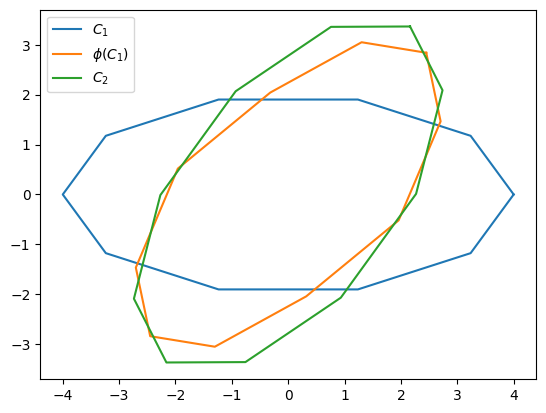

In [24]:
# Plot de la déformation minimisant l'énergie

def courbe_deform_plot(lambd,sigma,epsilon,a_tensor_init,z_tensor,courbe1,courbe2):
    '''
    Args : idem que decente_gradient_energie

    Retour : 2 tableaux de taille (n,1) : listes des abscisses et ordonnées de la courbe déformée
    '''
    courbe1_deform = deform_opti_torch(lambd,sigma,epsilon,a_tensor_init,courbe1,z_tensor,courbe1,courbe2)
    courbe1_deform = torch.cat((courbe1_deform, courbe1_deform[0].unsqueeze(0)), dim=0)
    
    return courbe1_deform[:,0], courbe1_deform[:,1]

lambd = 1
sigma = 1 

courbe1 = torch.cat((x1_vect,x2_vect), dim=1)
courbe2 = torch.cat((y1_vect,y2_vect), dim=1)
z_tensor = courbe1

a_tensor_init = torch.zeros((r, d), dtype=torch.float64, requires_grad=True) # Famille gén initiale
epsilon = 1e-5 # Condition d'arrêt

x1_deform, x2_deform = courbe_deform_plot(lambd,sigma,epsilon,a_tensor_init,z_tensor,courbe1,courbe2)

plt.figure()
plt.plot(x1,x2, label=r'$C_1$')
plt.plot(x1_deform,x2_deform, label=r'$\phi(C_1)$')
plt.plot(y1,y2, label=r'$C_2$')
plt.legend()
plt.show()

In [32]:
def descente_gradient_energie_bis(lambd,sigma,epsilon,pas_init,a_tensor_init,z_tensor,courbe1,courbe2):
    '''
    Args :
    lambd, sigma : réels > 0 : paramètres de la déform
    epsilon : réel > 0 donnant la condition d'arrêt de l'algo
    pas_init : réel > 0 : pas initiale pour l'algo
    a_tensor_init : tableau de taille (r,d) : liste de r vect de R^d, approximation initiale de la famille gén optimale du champ
    z_tensor : tableau de taille (r,d) : liste de r vect de R^d formant les points de base du champ
    courbe1,courbe2 : tableaux de taille (n,d) : courbes de R^d constituées chacune de n points

    Retour : famille gén réalisant une approx d'un minimum local de l'énergie
    '''
    pas = pas_init
    a_tensor = a_tensor_init
    energie_val_prec = float('inf')

    while True:
        energie_val = energie_torch(lambd,sigma,a_tensor,z_tensor,courbe1,courbe2)
        energie_val.backward()
        energie_grad = a_tensor.grad

        #print(energie_val.item(), energie_val_prec)
        
        if torch.linalg.norm(energie_grad) <= epsilon:
            break
            
        if energie_val.item() >= energie_val_prec:
            pas *= 0.8
        else:
            pas *= 1.2

        energie_val_prec = energie_val.item()
        a_tensor = a_tensor - pas*energie_grad
        a_tensor.retain_grad()

    return a_tensor.detach()

In [33]:
# Ex calcul min local de l'énergie par descente de gradient

lambd = 1
sigma = 1 
epsilon = 1e-5 # Condition d'arrêt
pas_init = 1

courbe1 = torch.cat((x1_vect,x2_vect), dim=1)
courbe2 = torch.cat((y1_vect,y2_vect), dim=1)
z_tensor = courbe1

a_tensor_init = torch.zeros((r, d), dtype=torch.float64, requires_grad=True) # Famille gén initiale


a_tensor_opti = descente_gradient_energie_bis(lambd,sigma,epsilon,pas_init,a_tensor_init,z_tensor,courbe1,courbe2)
a_tensor_opti

tensor([[-0.5200,  0.9519],
        [-0.7180,  0.8129],
        [-0.8712,  0.6319],
        [-0.9603,  0.4242],
        [-0.9484,  0.0714],
        [-0.7638, -0.4173],
        [-0.4524, -0.8366],
        [-0.1619, -1.0373],
        [ 0.0610, -1.0745],
        [ 0.2961, -1.0434],
        [ 0.5200, -0.9519],
        [ 0.7180, -0.8129],
        [ 0.8712, -0.6319],
        [ 0.9603, -0.4242],
        [ 0.9484, -0.0714],
        [ 0.7638,  0.4173],
        [ 0.4524,  0.8366],
        [ 0.1619,  1.0373],
        [-0.0610,  1.0745],
        [-0.2961,  1.0434]], dtype=torch.float64)

In [ ]:
def deform_euler_torch(N,sigma,a_tensor,x_tensor,z_tensor):
    '''
    Args : 

    Retour : 
    '''
    deform_iter = lambda x : x + 1/N*champ_vect_tensor(sigma,a_tensor,x,z_tensor)
    x_res = x_tensor
    for _ in range(N-1):
        x_res = deform_iter(x_res)
    return x_res

def courbe_deform_euler_plot(lambd,sigma,epsilon,a_tensor_init,z_tensor,courbe1,courbe2):
    '''
    Args : idem que decente_gradient_energie

    Retour : 2 tableaux de taille (n,1) : listes des abscisses et ordonnées de la courbe déformée
    '''
    courbe1_deform = deform_opti_torch(lambd,sigma,epsilon,a_tensor_init,courbe1,z_tensor,courbe1,courbe2)
    courbe1_deform = torch.cat((courbe1_deform, courbe1_deform[0].unsqueeze(0)), dim=0)
    
    return courbe1_deform[:,0], courbe1_deform[:,1]